In [120]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Load Metro Link Bike Share data, the data consisted of the operations from the 3rd quarter, 2016 (July - September). Note that the service launched on July 7, 2016.

In [27]:
trip_data = pd.read_csv("data/MetroBikeShare_2016_Q3_trips.csv")
trip_data.head()

,trip_id,duration,start_time,end_time,start_station_id,start_lat,start_lon,end_station_id,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type
0,1912818,180,7/7/2016 4:17,7/7/2016 4:20,3014,34.056610,-118.23721,3014,34.056610,-118.23721,6281,30,Round Trip,Monthly Pass
1,1919661,1980,7/7/2016 6:00,7/7/2016 6:33,3014,34.056610,-118.23721,3014,34.056610,-118.23721,6281,30,Round Trip,Monthly Pass
2,1933383,300,7/7/2016 10:32,7/7/2016 10:37,3016,34.052898,-118.24156,3016,34.052898,-118.24156,5861,365,Round Trip,Flex Pass
3,1944197,10860,7/7/2016 10:37,7/7/2016 13:38,3016,34.052898,-118.24156,3016,34.052898,-118.24156,5861,365,Round Trip,Flex Pass
4,1940317,420,7/7/2016 12:51,7/7/2016 12:58,3032,34.049889,-118.25588,3032,34.049889,-118.25588,6674,0,Round Trip,Walk-up


In [28]:
trip_data.shape

(55439, 14)

As expected, nearly 60% of all trips pertained to "Monthly Pass" option. This option is the perfect choice for the local residents who commute regularly.

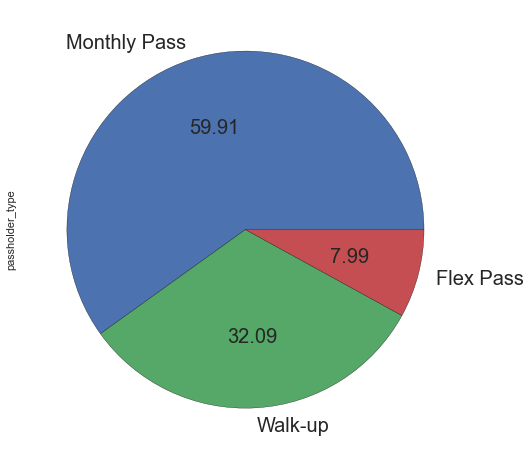

In [24]:
trip_data["passholder_type"].value_counts().plot.pie(subplots=True,figsize=(8,8),autopct='%.2f',fontsize=20);

We interest in the overall trip's duration. It is heavily right skewed. At 90th percentile, the trip duration is 2040 seconds( 34 minutes).

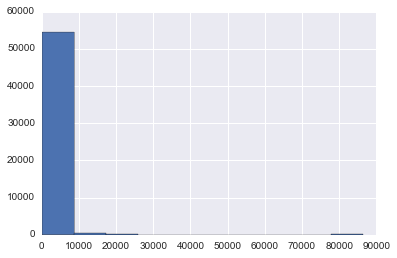

In [9]:
plt.hist(trip_data["duration"]);

In [29]:
trip_data["duration"].describe()

count    55439.000000
mean      1436.717473
std       4956.911177
min        120.000000
25%        420.000000
50%        660.000000
75%       1140.000000
max      86400.000000
Name: duration, dtype: float64

In [31]:
trip_data["duration"].median()

660.0

In [44]:
duration_90 = np.percentile(trip_data["duration"],90)
duration_90

2040.0

We plot Histogram of the overall trip's duration. To get a clearer view, the duration is capped 90th percentile.

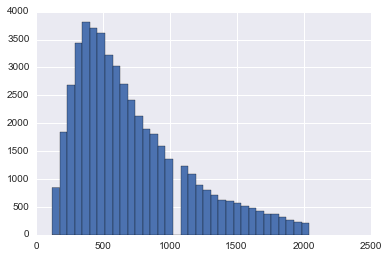

In [45]:
plt.hist(trip_data.loc[trip_data["duration"] <= duration_90,"duration"],bins=int(duration_90/60));

We interest in the revenue generated from all trips (see the [Pricing Options](https://bikeshare.metro.net/pricing/)). We ignore the initial subscription fee for Montly and Flex Pass since both data are not available. Firstly, we explore those trips that end within the first 30 minutes. We split the Histogram by a subscription type(Monthly Pass, Flex Pass, Walk-up).

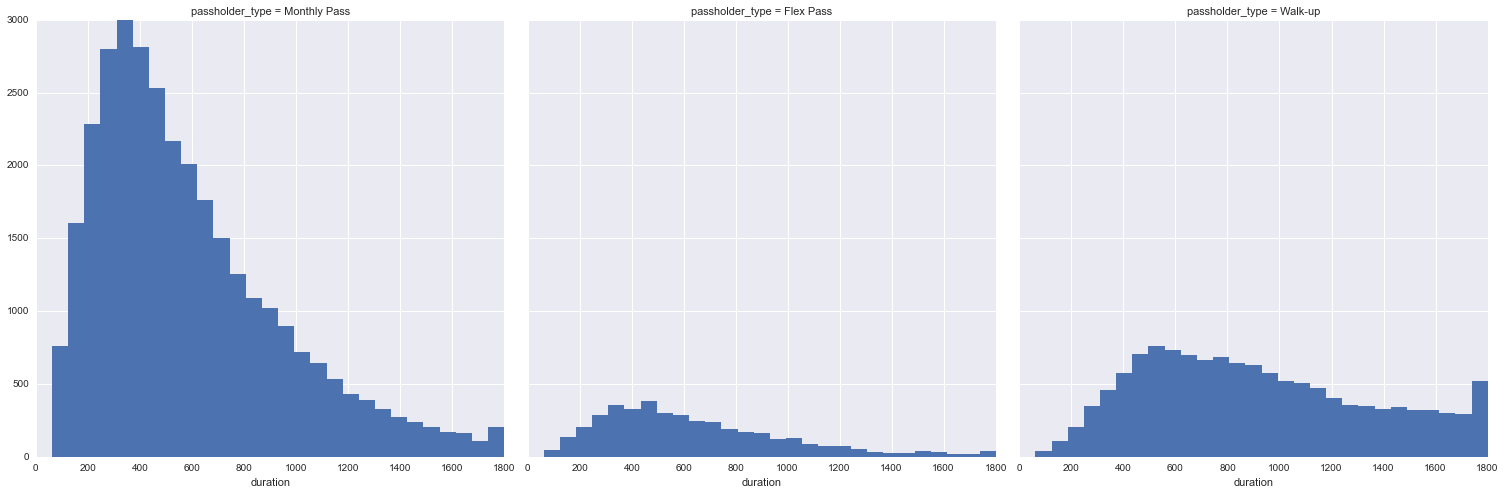

In [46]:
normal_data = trip_data.loc[trip_data["duration"] <= 1800]

g = sns.FacetGrid(data=normal_data,col="passholder_type",size=7)
g.map(plt.hist, "duration", lw=0, bins=np.linspace(0,1800,30));

For each additional 30 minutes, users will be incurred with an extra fee. We plot Histogram and investigate such trips. Most long trips were conducted by users with Walk-up subscription. As expected, they are more likely to be a visitor and spend more time exploring downtown LA.

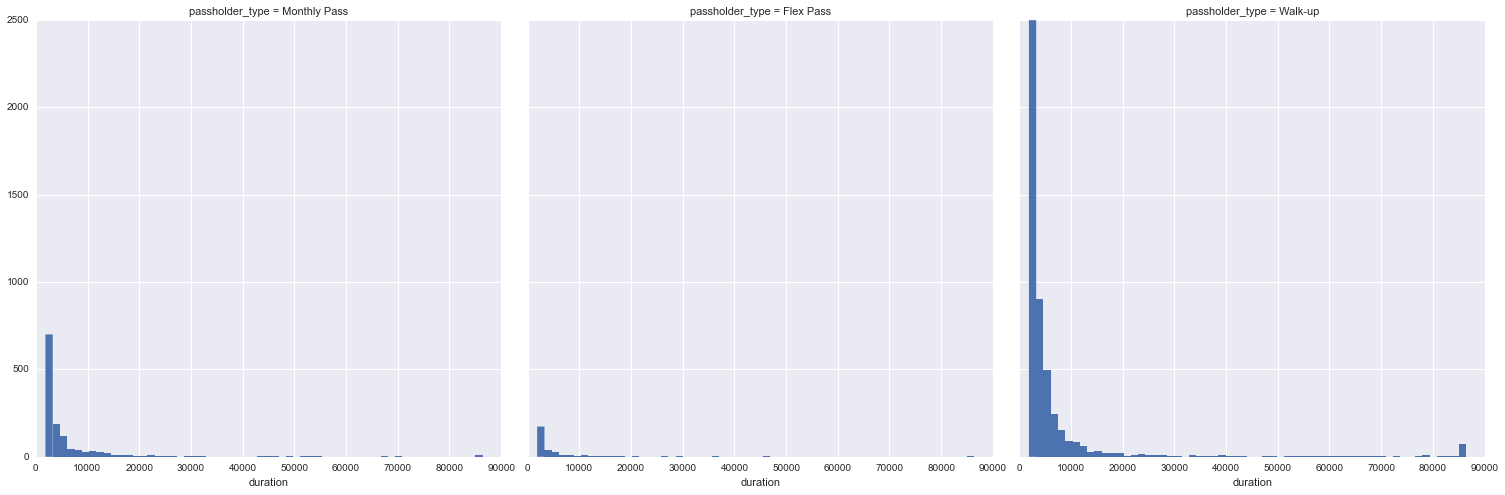

In [47]:
long_trip_data = trip_data.loc[trip_data["duration"] > 1800]

g = sns.FacetGrid(data=long_trip_data,col="passholder_type",size=7)
g.map(plt.hist, "duration", lw=0, bins=60);

In [165]:
long_trip_data.groupby("passholder_type")["duration"].median()

passholder_type
Flex Pass       3060
Monthly Pass    3060
Walk-up         3240
Name: duration, dtype: int64

In [55]:
long_trip_data.groupby("passholder_type")["duration"].count()

passholder_type
Flex Pass        321
Monthly Pass    1323
Walk-up         4922
Name: duration, dtype: int64

Next, we found that nearly 90% of trips are One-Way trip.

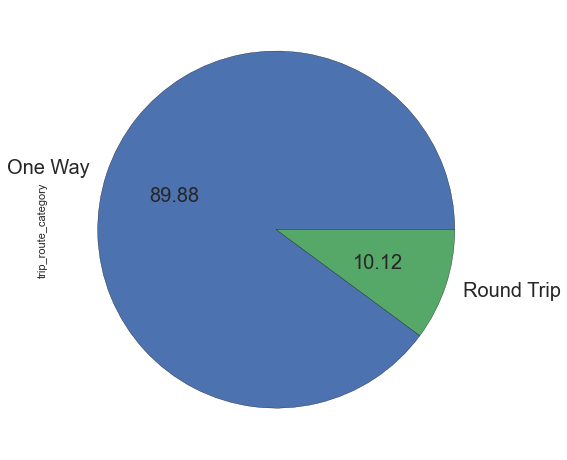

In [118]:
trip_data["trip_route_category"].value_counts().plot.pie(figsize=(8,8),autopct='%.2f',fontsize=20);

We facet the Pie Chart by a subscription type and found that a significantly more proportion of Round Trip is conducted by Walk-up users( 20%, compared to ~5% from Monthly and Flex Pass subscription). This aligns well with our earlier finding since Walk-up users spent more time traveling back and forth.

In [69]:
ct = pd.crosstab(trip_data["trip_route_category"],trip_data["passholder_type"])
ct

passholder_type,Flex Pass,Monthly Pass,Walk-up
trip_route_category,,,
One Way,4179,31488,14160
Round Trip,252,1728,3632


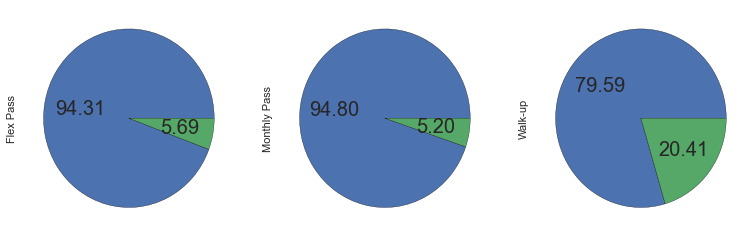

In [136]:
ct.plot.pie(subplots=True,figsize=(13,4),autopct='%.2f',fontsize=20,labels=None);


To prepare the data used in Tableau, we calculate revenue generated for each trip.

In [156]:
import math
from __future__ import division

In [160]:
def calculate_revenue(d):
    if d["passholder_type"] == "Walk-up":
        return (math.ceil(d["duration"]/1800) ) * 3.5
    elif d["passholder_type"] == "Flex Pass":
        return (math.ceil(d["duration"]/1800) ) * 1.75
    else:
        return (math.ceil(d["duration"]/1800) - 1 ) * 1.75
        

trip_data["revenue_gain"] = trip_data.apply(calculate_revenue,axis=1)

We also calculate a (typical) distance between each station. The usual route taken is calculated by GoogleMaps API. Noted: you need to install the GoogleMap API for Python via [this link](https://github.com/googlemaps/google-maps-services-python) and use your own API key.

In [181]:
import googlemaps

gmaps = googlemaps.Client(key='---Your API Key---')

In [183]:
distance_info = gmaps.distance_matrix(origins=(34.04607,-118.23309),destinations=(34.05661,-118.23721),mode="bicycling")

/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:122: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning


In [190]:
#unit in KM
distance_info["rows"][0]["elements"][0]["distance"]["value"]
#unit in seconds
distance_info["rows"][0]["elements"][0]["duration"]["value"]

394

In [179]:
trip_data[6:7]

,trip_id,duration,start_time,end_time,start_station_id,start_lat,start_lon,end_station_id,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,revenue_gain
6,1944073,600,7/7/2016 12:54,7/7/2016 13:04,3022,34.04607,-118.23309,3014,34.05661,-118.23721,5721,30,One Way,Monthly Pass,0.0


Then, we store the processed data and switch to Tableau for Explanatory Analysis.

In [166]:
trip_data.to_csv("data/processed.csv",index=False)